# The Symmetric Travelling Salesman Problem

Recall that in the Travelling Salesman Problem (TSP) we have a set of cities $i=1,\ldots, n$ and that we must find a tour which visits every city exactly once in such a way that minimizes the total distance travelled. The distance between any two cities $i, j$ is given by $c_{ij} > 0$. More generally, this can be thought of as the problem of finding the shortest *Hamiltonian tour* on a complete graph $G=(V,E)$, where the nodes of the graph correspond to the cities and the edges are routes between the cities.

In this notebook, you will implement models for the special case where the distance between each pair of locations (or nodes) is symmetric, that is, the case where $c_{ij} = c_{ji}$ for each $(i,j)\in E$. In this case, we can represent the problem using an *undirected* graph and simplify the formulation.

### Instructions for assignment

This assignment is split into three parts. The first part guides you in the implementation of the Dantzig-Fulkerson-Johnson (DFS) formulation of the TSP you have already seen in the lectures. In the second part, you will be asked to implement an alternative formulation called the *multistage-insertion* formulation. In the third part you will compare the performance of these two implementations.

This notebook also contains an additional section which guides you on how to implement the DFS formulation in a more efficient manner by using a feature of Gurobi called a *callback function*. This is provided for interest only and will not be assessed.

Code to generate instances of the TSP problem, as well to plot solutions is provided to help you test your implementations.

Please complete the exercises in this Jupyter notebook, and submit this to Moodle. Where you are provided with the beginning of a function, do not change its name or its main arguments (you may on the other hand add optional keyword arguments if you wish). An additional file "instance_20_nodes.pkl" and code to read this, are provided for the purposes of marking your implementations. 

Marks will mainly be awarded for correct implementations, but some marks will also be awarded for good coding practice. Before submitting, be sure that all of the code runs without error when you select **Kernel->Restart & Run All** in the menu above. The submission deadline is **Friday 19th November at 16:00**.

# Generating random instances of the TSP

The following cell of code defines a function for generating random instances of the symmetric TSP for a given number of cities. This will be used to help test your implementations of the TSP.

The function works by uniformly randomly generating points on the unit square $(0,1) \times (0,1)$, and then calculating the distance matrix for these points. For the purposes of plotting, the function returns the randomly generated points alongside the distance matrix.

In [1]:
!python -m pip install numpy scipy

In [2]:
from random import random, seed
import math
import numpy as np
from scipy.spatial import distance_matrix

np.random.seed(5)

def generate_points_and_distance(n : int):
    pts = np.random.random((n, 2))
    dist = distance_matrix(pts, pts)
    return pts, dist

The following cells demonstrate how to use this function, extract distances, and plot the locations.

In [3]:
n=10
pts, dist = generate_points_and_distance(n)
pts, dist

(array([[0.22199317, 0.87073231],
        [0.20671916, 0.91861091],
        [0.48841119, 0.61174386],
        [0.76590786, 0.51841799],
        [0.2968005 , 0.18772123],
        [0.08074127, 0.7384403 ],
        [0.44130922, 0.15830987],
        [0.87993703, 0.27408646],
        [0.41423502, 0.29607993],
        [0.62878791, 0.57983781]]),
 array([[0.        , 0.05025591, 0.37155561, 0.64804982, 0.68709553,
         0.19352849, 0.74541617, 0.88818713, 0.60595567, 0.50010156],
        [0.05025591, 0.        , 0.41655466, 0.68763826, 0.73641997,
         0.21984512, 0.79566964, 0.9320054 , 0.65620702, 0.54121091],
        [0.37155561, 0.41655466, 0.        , 0.29276974, 0.46530619,
         0.42690368, 0.45587387, 0.51701548, 0.32426196, 0.14395701],
        [0.64804982, 0.68763826, 0.29276974, 0.        , 0.57395301,
         0.71962703, 0.48481144, 0.26963039, 0.41606249, 0.15024738],
        [0.68709553, 0.73641997, 0.46530619, 0.57395301, 0.        ,
         0.59158523, 0.14747135, 

In [4]:
i, j = 0, 1
print(f"The distance between point {i}, {pts[i]}, and point {j}, {pts[j]}, is {dist[i,j]}")

The distance between point 0, [0.22199317 0.87073231], and point 1, [0.20671916 0.91861091], is 0.05025590575928056


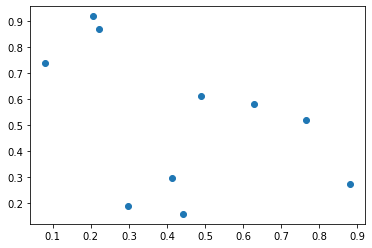

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(pts[:,0], pts[:,1])

# 1. Implementing the Dantzig-Fulkerson-Johnson Formulation

[//]: # (Let $x_{ij}$ for $i=1,\ldots, n,\ j=i,\ldots,n$ be the binary decision indicating whether the edge ${i,j}$ in their tour of the cities.)
Let $x_{e}$ be the binary decision indicating whether the edge $e\in E$ is used in the Hamiltonian tour.
The Dantzig-Fulkerson-Johnson (DFJ) formulation of the symmetric TSP (as seen in the lectures) can then be stated as follows:

\begin{align}
% \min \sum_{i=1}^{n} & \sum_{j=i}^n c_{ij} x_{ij},\\
\min \sum_{e\in E} & c_e x_e \\
%\text{subject to} \sum_{e\in \delta(i)} x_{e} &= 2 \ \forall i=1,\ldots,n,\\
\text{subject to} \sum_{e\in \delta(i)} x_{e} &= 2 \ \forall i\in V,\\
\sum_{\{i,j\}\in E: i,j\in S} x_{ij} &\leq |S| - 1\ \forall S \subset V,
\end{align}

where $\delta(i)$ represents the set of edges containing node $i$ as an end-point.

The implementation of the DFJ is complicated by the fact that the number of subtour elimination constraints is exponential with respect to the number of nodes in the problem. This means that for even moderately sized instances of the TSP, it is impractical to add all subtour elimination constraints to the model. Instead, an iterative process can be used to solve the problem whereby we first solve the model without any subtour elimination constraints, find any broken subtour elimination constraints, add these to our model, and then resolve model. This process continues until no more broken constraints are found, at which point we have the optimal tour.

To guide you in implementing this, we have broken down this approach into three steps.

## 1a) Implement Base Model

The first step is to implement the TSP without any subtour elimination constraints. 

Note that although we stated the problem above in terms of a graph, there isn't a need to use `networkx` to implement it, as the graph structure is fairly simple. Instead, it is recommended to implement it using integer indices. For a problem with $n$ cities, the decision variables can be indexed as $x_{ij}$ for $i=0,\ldots,n-1\, \ \text{and } j=i+1,\ldots,n-1$.

### i) Complete the function below which takes as input a distance matrix, constructs the base model, and returns both the `Gurobi.Model` object alongside the decision variables `x`.

In [6]:
from gurobipy import quicksum, Model, GRB, tupledict, tuplelist

## NOTE: **gurobi_params collects any keywords arguments
## These are used to set Gurobi parameters
## You will see how this is used later.
def construct_base_model(dist, **gurobi_params):
    m = Model()
    n = dist.shape[0] # number of nodes
    for k,val in gurobi_params.items():
        m.setParam(k, val)    
    x = m.addVars( ((i,j) for i in range(n) for j in range(i+1,n)) ,vtype=GRB.BINARY)
    m.setObjective(quicksum(dist[i,j]*x[i,j] for i in range(n) for j in range(i+1,n) ) )
    m.addConstrs( quicksum(x[i,j] for j in range(i+1,n) ) + quicksum(x[j,i] for j in range(i)) == 2 for i in range(n) )
    return m, x

### ii) Next write a function which takes as input the model and x variables, solves the problem and returns the solution expressed a list of edges.

In [7]:
def solve_model(m, x):
    m.optimize()
    edges = [k for k,v in x.items() if int(v.x)]
    return edges

The code below defines a function for plotting a solution and is provided to enable you to test your code.

In [8]:
m, x = construct_base_model(dist)
edges = solve_model(m, x)

Academic license - for non-commercial use only - expires 2022-10-10
Using license file C:\Users\aliatimi\gurobi.lic
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 10 rows, 45 columns and 90 nonzeros
Model fingerprint: 0xb72f5f5f
Variable types: 0 continuous, 45 integer (45 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-02, 9e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]
Found heuristic solution: objective 4.4626858
Presolve time: 0.01s
Presolved: 10 rows, 45 columns, 90 nonzeros
Variable types: 0 continuous, 45 integer (45 binary)

Root relaxation: objective 1.992145e+00, 9 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       1.9921451    1.99215  0.00%     

In [9]:
def plot_solution(pts, edges):
    n=len(pts)
    for i,j in edges:
        plt.plot([pts[i,0], pts[j,0]], [pts[i,1], pts[j,1]], 'ro-')
    for i in range(n):
        plt.annotate(i, pts[i,:])

In [10]:
edges

[(0, 1),
 (0, 5),
 (1, 5),
 (2, 7),
 (2, 9),
 (3, 7),
 (3, 9),
 (4, 6),
 (4, 8),
 (6, 8)]

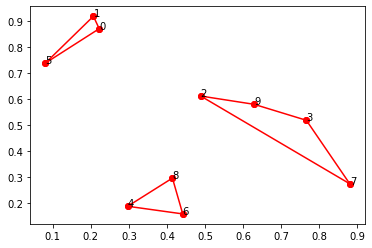

In [11]:
plot_solution(pts, edges)

## 1b) Implement separation algorithm

After solving the optimization problem without subtour elimination constraints, you will most likely find your solution has multiple subtours. Although it is easy to see by eye what are the subtours, in order to be able to solve problems practically, it is necessary to have code which can automatically find these for a given solution.

*For the purposes of illustration, in the unlikely event that the example above did not have any subtours, please rerun the code above with a different random seed*

### i. Complete the function below which takes as input a set of edges and the number of vertices in the graph, and returns a subset of the edges which form a subtour (or full tour)

*Hint: note that the edges returned by solving the base problem will always give a permutation meaning that to find a subtour/cycle, it suffices to start at any given edge, and follow the end-point of each edge until we return to the starting point. If this procedure returns all the edges, then the selected edges already form a single tour.*

In [12]:
from collections import defaultdict
def find_subtour(edges, n):    
    d = defaultdict(list)
    for edge in edges:
        d[edge[0]].append(edge[1])
        d[edge[1]].append(edge[0])
    cycle= list()
    v=0
    while v is not None:
        cycle.append(v)
        v_next=None
        for s in d[v]:
            if s in cycle: continue 
            v_next=s; break
        v = v_next
    L = len(cycle)
    return cycle

### ii. Test your code by running `find_subtour` on the edges returned by solving the base model above. Add the subtour elimination constraint to the model, reoptimize the model, and plot the new solution.

*For the purposes of illustration, in the unlikely event that the example above did not have any subtours, please rerun the code above with a different random seed.*

1.992145101545653


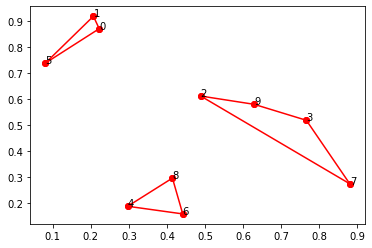

2.3317797616914184


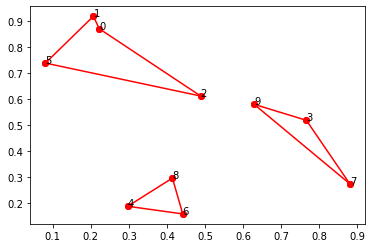

2.5203881414955656


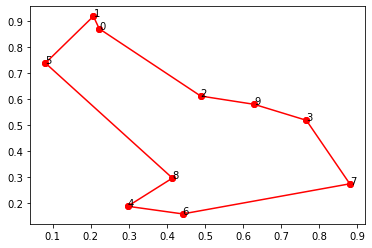

In [13]:
m, x = construct_base_model(dist,outputFlag=0)
n = dist.shape[0]
while True:
    edges = solve_model(m,x)
    print(m.objVal)
    plot_solution(pts, edges),plt.show()
    cycle=find_subtour(edges,n)
    L = len(cycle)
    if L==n: break
    m.addConstr(quicksum(x[min(cycle[i],cycle[j]),max(cycle[i],cycle[j])] for i in range(L) for j in range(i+1,L)) <= L-1 )

# 1c) Putting it all together - implementing row generation algorithm

If you are fortunate, after adding a single subtour elimination constraint, an optimal feasible solution will have been found. Usually however, we must add multiple subtour elimination constraints to solve the TSP.

Using the code you have already written above, complete function below which takes as input a distance matrix, solves the TSP by iteratively adding subtour elimination constraints and reoptimizing, and returns the optimal solution (the edges in the optimal tour) and the optimal objective value.

In [14]:
def solve_tsp_row_gen(dist,iter_log=True, **gurobi_params):
    n = dist.shape[0] # number of nodes
    m, x = construct_base_model(dist, **gurobi_params)
    i=0
    while True:
        i+=1 # Increment counter
        edges = solve_model(m,x)
        cycle=find_subtour(edges,n); L = len(cycle)
        if L==n: break
        m.addConstr(quicksum(x[i,j] for i in cycle for j in cycle if j>i ) <= L-1 )
    if(iter_log): print("Terminated after", i, "iterations")
    return edges, m.objVal

The following two cells test your implementation works. Do not modify as this will be used for marking purposes.

In [15]:
import pickle
with open('instance_20_nodes.pkl', 'rb') as f:
    test_pts, test_dist = pickle.load(f)
opt_sol, opt_val = solve_tsp_row_gen(test_dist, outputFlag=0)
opt_val

Terminated after 8 iterations


4.119072298102383

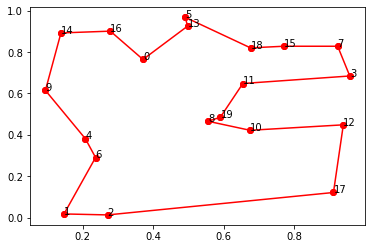

In [16]:
plot_solution(test_pts, opt_sol)

# 2. Implementation of Multistage-Insertion Formulation

There are many alternate formulations of the TSP. The multistage-insertion (MS) formulation of the TSP has the advantage of having only a polynomial number of constraints unlike the DFJ formulation.

The formulation can be found in Section 3 of the paper *On the equivalence of the multistage-insertion and cycle-shrink formulations of the symmetric traveling salesman problem* by Arthanari and Usha (2001). 

**Complete the Python function below which takes as argument a distance matrix and returns the optimal tour and optimal tour length.**

#### Hints

- *Test your implementation is correct by comparing the output with that of your implementation of the DFJ formulation. For a given instance the total distance of the optimal tours should match (although not necessarily the optimal tours themselves).*

- *Be careful with your indexing as Python indexes from 0 rather than 1.*

- *Note that the objective value in this formulation needs to be adjusted by a constant value to get the total distance of the tour*

In [17]:
def solve_tsp_ms(dist, **gurobi_params):
    n = dist.shape[0] # number of nodes
    m = Model()   
    for k,val in gurobi_params.items():
        m.setParam(k, val)

    # Add variables
    x = m.addVars(((i,j,k) for k in range(3,n) for i in range(k) for j in range(i+1,k)) ,vtype=GRB.BINARY)
    m.setObjective(quicksum((dist[i,k]+dist[j,k]-dist[i,j]) * x[i,j,k] for k in range(3,n) for i in range(k) for j in range(i+1,k)),GRB.MINIMIZE)
    m.addConstrs(quicksum(x[i,j,k] for i in range(k) for j in range(i+1,k)) == 1 for k in range(3,n))
    m.addConstrs(quicksum(x[i,j,k] for k in range(3,n)) <= 1 for i in range(3) for j in range(i+1,3))
    m.addConstrs(quicksum(x[i,j,k] for k in range(j+1,n)) -
                 quicksum(x[i,s,j] for s in range(i+1,j))-
                 quicksum(x[r,i,j] for r in range(i)) <= 0 
                 for j in range(3,n-1) for i in range(j))
    m.optimize()

    edges = [(i,j) for i in range(n-1) for j in range(i+1,n) if ((j<3) or 
                 int(sum([x[i,s,j].x for s in range(i+1,j)])+
                 sum([x[r,i,j].x for r in range(i)]))) and not
                 int(sum([x[i,j,k].x for k in range(max(j+1,3),n)]))
            ]
    return edges, m.objVal

The following two cells test your implementation works. Do not modify as these will be used for marking purposes.

In [18]:
with open('instance_20_nodes.pkl', 'rb') as f:
    test_pts, test_dist = pickle.load(f)
opt_sol, opt_val = solve_tsp_ms(test_dist, outputFlag=0)

In [19]:
#The total distance is the optimal value + c[0,1] + c[0,2] + c[1,2]
sum([test_dist[i,j] for i in range(3) for j in range(i+1,3)]) + opt_val

4.119072298102382

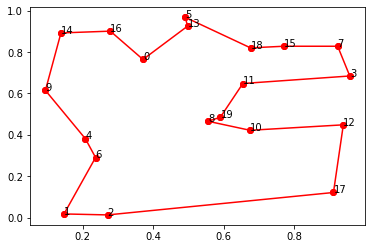

In [20]:
plot_solution(test_pts, opt_sol)

# 3. Comparison of solution times

You are now required to compare the performance of each implementation of the TSP.

**For graphs with n=10, 20, 30, 40 nodes, generate 20 random instances, solve each of these with both implementations and record the average solution time for each method and instance size.**

**Plot the node size against average solution time for each implementation.**

The following cells show you how to time the solution of the TSP for the MS implementation, and how to use matplotlib to do a simple line plot. The function `np.mean` may be useful for calculating the average of a list of numbers.

In [21]:
import time

def average_solution_time(method,n,rand_instances=20,**kwargs):
    sol_time = np.zeros(rand_instances)
    print(f"Running {rand_instances} random instances: [",end="")
    for i in range(rand_instances):
        print(".",end="")
        pts, dist = generate_points_and_distance(n)
        tic = time.perf_counter()
        method(dist, outputFlag=0,**kwargs)
        toc = time.perf_counter()
        sol_time[i] = toc-tic
    print("]")
    return np.mean(sol_time)

In [22]:
n_list = [10,20,30,40]
dfj_times = [0] * 4
ms_times = [0] * 4
for i,n in enumerate(n_list):
    dfj_times[i] = average_solution_time(solve_tsp_row_gen,n,iter_log=False)
    print(f"DFJ with n={n} averages {dfj_times[i]:0.4f} seconds")
    ms_times[i]  = average_solution_time(solve_tsp_ms,n)
    print(f"MS with n={n} averages {ms_times[i]:0.4f} seconds")

Running 20 random instances: [....................]
DFJ with n=10 averages 0.0076 seconds
Running 20 random instances: [....................]
MS with n=10 averages 0.0113 seconds
Running 20 random instances: [....................]
DFJ with n=20 averages 0.0776 seconds
Running 20 random instances: [....................]
MS with n=20 averages 0.1827 seconds
Running 20 random instances: [....................]
DFJ with n=30 averages 1.0439 seconds
Running 20 random instances: [....................]
MS with n=30 averages 0.6580 seconds
Running 20 random instances: [....................]
DFJ with n=40 averages 6.3215 seconds
Running 20 random instances: [....................]
MS with n=40 averages 1.7832 seconds


Text(0.5, 1.0, 'Average solution times')

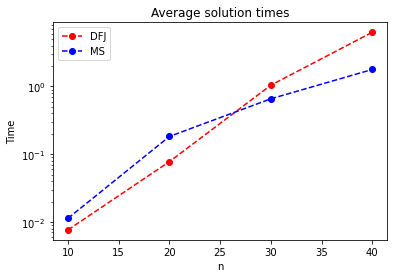

In [23]:
plt.semilogy(n_list,dfj_times, '--o', color='r', label='DFJ')
plt.semilogy(n_list,ms_times, '--o', color='b', label='MS')
plt.xlabel('n')
plt.ylabel('Time')
plt.legend()
plt.title("Average solution times")
#Comments: From the graph our conjecture is that the DFJ algorithm with 
#row generation is better for fewer cities, while Multistage insertion is 
#superior for higher number of cities.

# Bonus Material: Branch-and-lazy-cut Implementation of DFJ formulation

### Non-assessed

A more modern way of implementing the TSP is to add the subtour elimination constraints during the branch-and-bound algorithm. This can be done by defining a *callback* function. This is a function that is called periodically during the solution algorithm and can be used for various other purposes such as finding new heuristic solutions for the solver, adding cutting planes, or simply printing more detailed information about the solution process.

In this instance, we want to use a callback function to add what Gurobi refers to as *lazy constraints*. These are constraints which are required in a model formulation, but which are only added in the branch-and-bound algorithm as they are needed.

**Below is a partial implementation of solving the TSP via callbacks. Complete the callback function `subtourelim`.**

*Note that within a callback function, you must use the function `model.cbGetSolution` to extract the current solution, and `model.cbLazy` rather than `model.addConstr` to add a constraint.*

In [24]:
def solve_tsp_branch_and_cut(dist, **gurobi_params):
    
    n = dist.shape[0]
    m, x = construct_base_model(dist)
    for k,val in gurobi_params.items():
        m.setParam(k, val)
    
    m._x = x # Attach solution to model object so this can be accessed in callback function
    m.Params.lazyConstraints = 1 # This setting is required to add lazy constraints
    def subtourelim(model, where):
        # This condition means this code is only ran when Gurobi finds a new integer solution
        # which is feasible for the current set of constraints
        if where == GRB.Callback.MIPSOL: 
            x_vals = model.cbGetSolution(model._x) # Extract current solution
            
    m.optimize(subtourelim) # optimize takes callback function as an optional argument
    vals = m.getAttr('x', x)
    opt_sol = tuplelist((i, j) for i, j in x.keys() if vals[i, j] > 0.5)
    return opt_sol, m.objVal

The following two cells test your implementation works.

In [25]:
with open('instance_20_nodes.pkl', 'rb') as f:
    test_pts, test_dist = pickle.load(f)
opt_sol, opt_val = solve_tsp_branch_and_cut(test_dist, outputFlag=0)

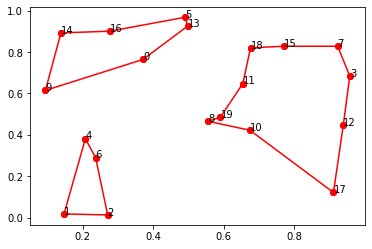

In [26]:
plot_solution(test_pts, opt_sol)

**Compare the performance of the MS implementation and the new callback implementation of the DFS formulation in the same way as above.**

In [27]:
n_trials = 20
n_list = [10, 20, 30, 40]
